<a href="https://colab.research.google.com/github/shamiyack/Sales-forecasting-project/blob/main/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=14
matplotlib.rcParams['ytick.labelsize']=14
matplotlib.rcParams['text.color']='k'




In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import pandas as pd
dataset=pd.read_excel('gdrive/My Drive/Sample - Superstore.xls')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
dataset.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [ ]:
set(dataset['Category'])

{'Furniture', 'Office Supplies', 'Technology'}

# Data preprocessing

### First we  analyse the time series of Furniture Sales followed by other categories.

In [ ]:
furniture=dataset.loc[dataset['Category']=='Furniture']
#This shows that we have time-series data of 4 years for furniture sales.
print(furniture['Order Date'].min())
print(furniture['Order Date'].max())

2014-01-06 00:00:00
2017-12-30 00:00:00


In [ ]:
cols=['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit']
furniture.drop(cols,axis=1,inplace=True)

In [ ]:
#furniture data
furniture.sort_values('Order Date')
furniture.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [ ]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing Time series data

In [ ]:
furniture=furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [ ]:
# Averaging Daily Sales
y=furniture['Sales'].resample('MS').mean()

In [ ]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

# Furniture data time-series visualization

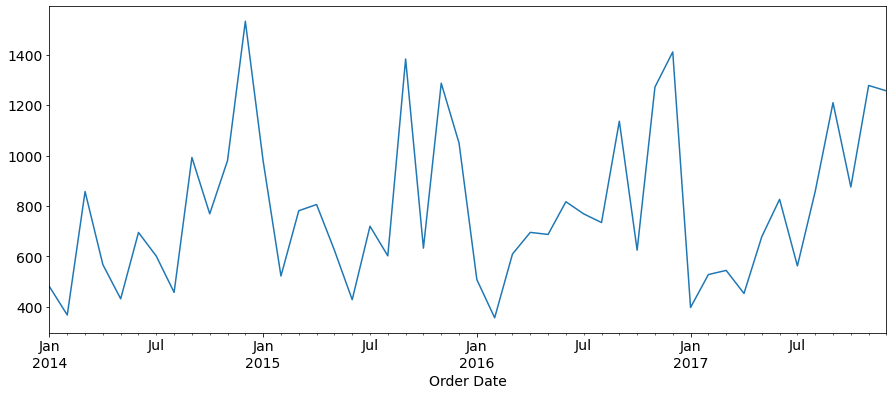

In [ ]:
y.plot(figsize=(15,6))

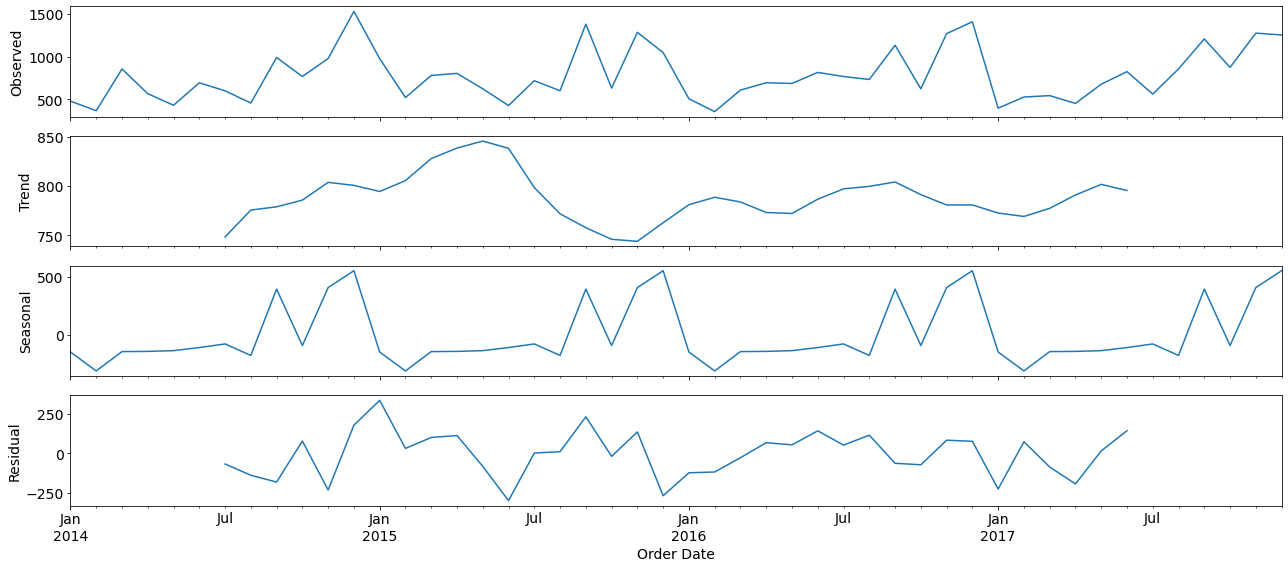

In [ ]:
from pylab import rcParams
rcParams['figure.figsize']=18,8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

 **Time Series forecasting with ARIMA Model**

In [ ]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1523.8452414834323
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1525.5728252197762
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758102
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091573
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5702446844217
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2617.780902824887
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1415.3065464689478
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785671879367
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1342.9618494756428
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(

Fitting the ARIMA Model using the Optimal **parameters**

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y, order = (1,1,1),
                               seasonal_order = (1,1,0,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


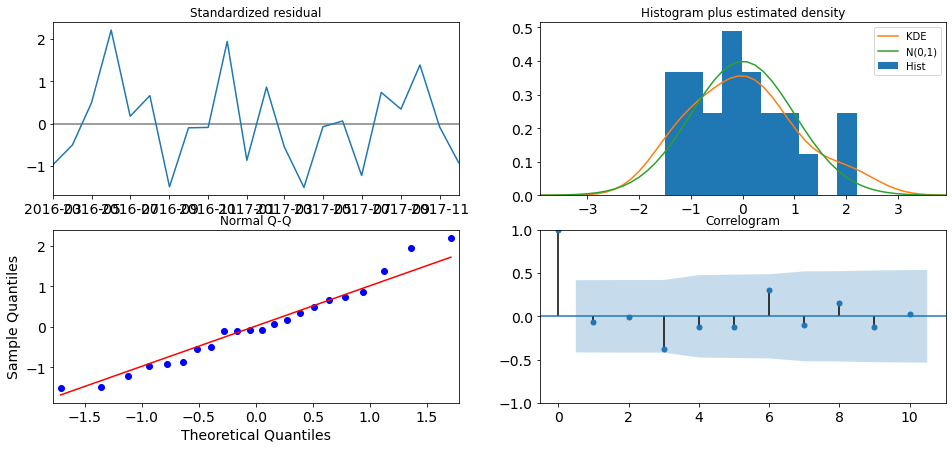

In [ ]:
results.plot_diagnostics(figsize = (16,7))
plt.show()

# Validating Forecasts

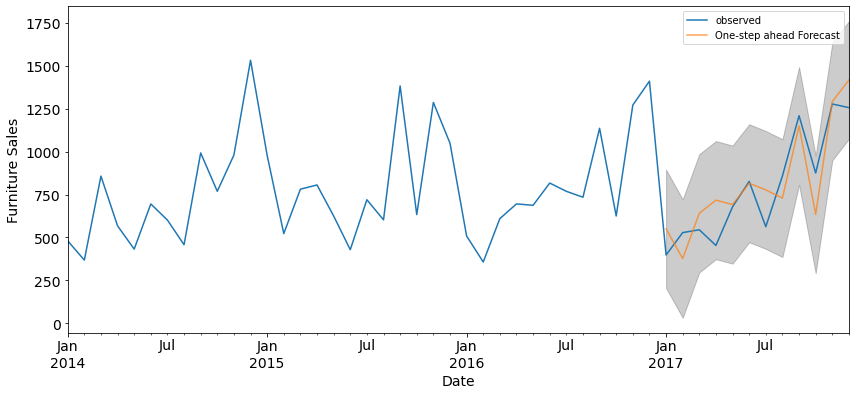

In [ ]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = .7, figsize = (14, 6))

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
monthly_forecasted = pred.predicted_mean
monthly_truth = y['2017-01-01':]

mse = ((monthly_forecasted -monthly_truth)**2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 22993.57
The Root Mean Squared Error of our forecasts is 151.64


Producting and Visualizing Forecasts

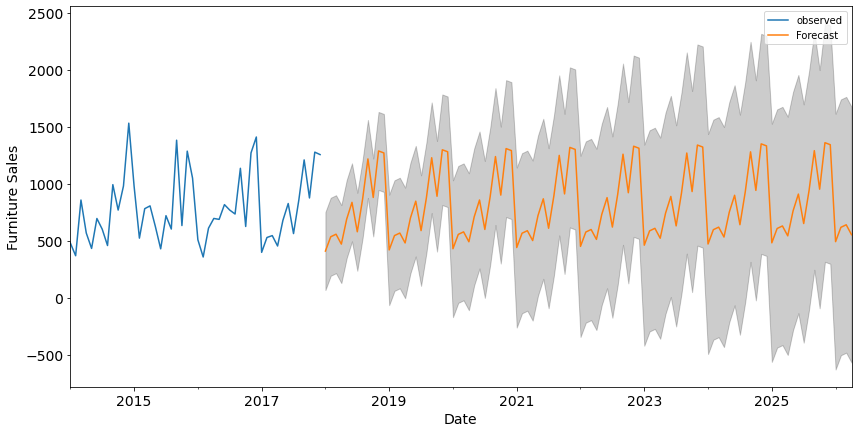

In [ ]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label = 'observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax = ax, label ='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Our ARIMA prediction model clearly captured the office supplies sales seasonality.

Time Series of Technology vs. Furniture

In [ ]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']
Tech = dataset.loc[dataset['Category'] == 'Technology']
cols=['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit']
furniture.drop(cols,axis=1,inplace=True)
Tech.drop(cols,axis=1,inplace=True)
furniture = furniture[['Order Date', 'Sales']]
Tech = Tech[['Order Date', 'Sales']]
furniture = furniture.sort_values('Order Date')
Tech = Tech.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
Tech = Tech.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
Tech = Tech.set_index('Order Date')
furniture.head()



,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [ ]:
Tech.head()

,Sales
Order Date,
2014-01-06,1147.94
2014-01-09,31.20
2014-01-13,646.74
2014-01-15,149.95
2014-01-16,124.20


In [ ]:
y_Tech =Tech['Sales'].resample('MS').mean()
y_furniture = furniture['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
Tech = pd.DataFrame({'Order Date': y_Tech.index, 'Sales': y_Tech.values})


In [ ]:
store = furniture.merge(Tech, how = 'inner', on = 'Order Date')
store.rename(columns = {'Sales_x': 'furniture_sales', 'Sales_y': 'Tech_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,Tech_sales
0,2014-01-01,480.194231,449.041429
1,2014-02-01,367.931600,229.787143
2,2014-03-01,857.291529,2031.948375
3,2014-04-01,567.488357,613.028933
4,2014-05-01,432.049188,564.698588


Visualizing the Sales Data

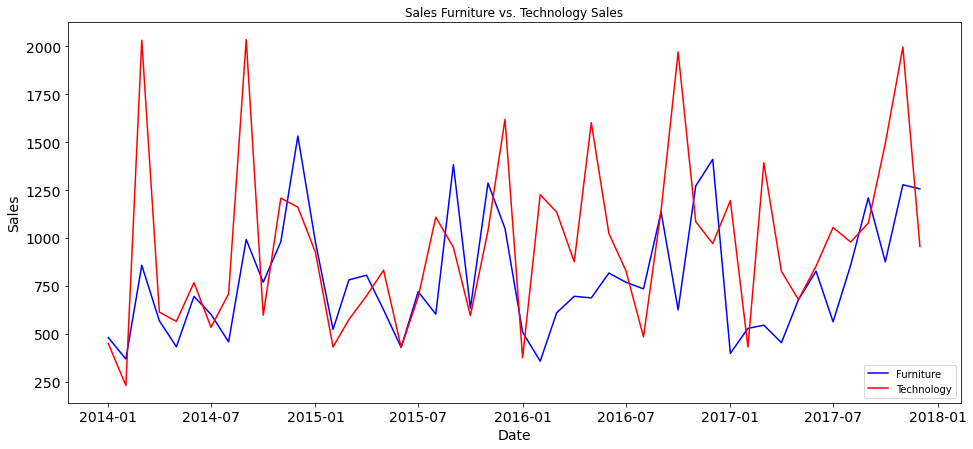

In [ ]:
plt.figure(figsize = (16, 7))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'Furniture')
plt.plot(store['Order Date'], store['Tech_sales'], 'r-', label = 'Technology')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Furniture vs. Technology Sales')
plt.legend()
plt.show()

Time Series Modeling with Prophet

In [ ]:
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width = 0.95)
furniture_model.fit(furniture)

Tech = Tech.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
Tech_model = Prophet(interval_width=0.95)
Tech_model.fit(Tech)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
furniture_forecast = furniture_model.make_future_dataframe(periods = 36, freq = 'MS')
furniture_forecast = furniture_model.predict(furniture_forecast)


In [ ]:
Tech_forecast = Tech_model.make_future_dataframe(periods = 36, freq = 'MS')
Tech_forecast = Tech_model.predict(Tech_forecast)

<Figure size 1152x504 with 0 Axes>

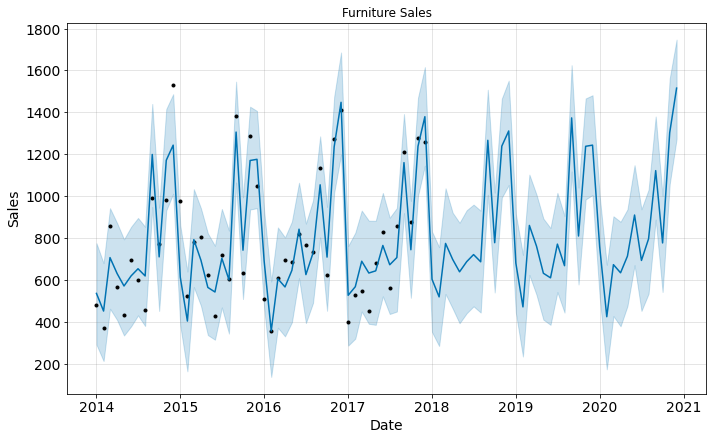

In [ ]:
plt.figure(figsize = (16,7))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

<Figure size 1152x504 with 0 Axes>

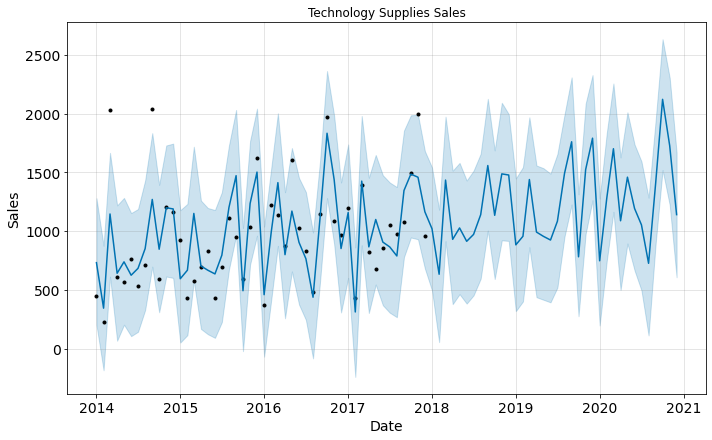

In [ ]:
plt.figure(figsize = (16,7))
Tech_model.plot(Tech_forecast, xlabel = 'Date', ylabel = 'Sales')

plt.title('Technology Supplies Sales')
plt.show()

Time Series of Office Supplies vs. Furniture

In [ ]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']
office = dataset.loc[dataset['Category'] == 'Office Supplies']
cols=['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit']
furniture.drop(cols,axis=1,inplace=True)
office.drop(cols,axis=1,inplace=True)
furniture = furniture[['Order Date', 'Sales']]
office = office[['Order Date', 'Sales']]
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [ ]:
office.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,685.340
2014-01-07,10.430


In [ ]:
y_office = office['Sales'].resample('MS').mean()
y_furniture = furniture['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})


In [ ]:
store1=furniture.merge(office,how='inner',on='Order Date')
store1.rename(columns={'Sales_x':'furniture_sales','Sales_y':'office_sales'},inplace=True)
store1.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


Visualizing the Sales Data

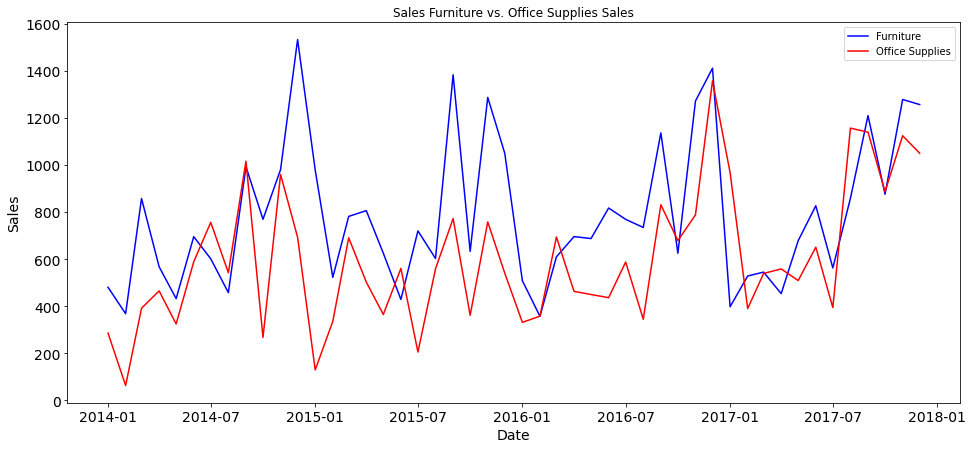

In [ ]:
plt.figure(figsize = (16, 7))
plt.plot(store1['Order Date'], store1['furniture_sales'], 'b-', label = 'Furniture')
plt.plot(store1['Order Date'], store1['office_sales'], 'r-', label = 'Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Furniture vs. Office Supplies Sales')
plt.legend()
plt.show()

In [ ]:
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width = 0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
furniture_forecast = furniture_model.make_future_dataframe(periods = 36, freq = 'MS')
furniture_forecast = furniture_model.predict(furniture_forecast)


In [ ]:
office_forecast = office_model.make_future_dataframe(periods = 36, freq = 'MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1152x504 with 0 Axes>

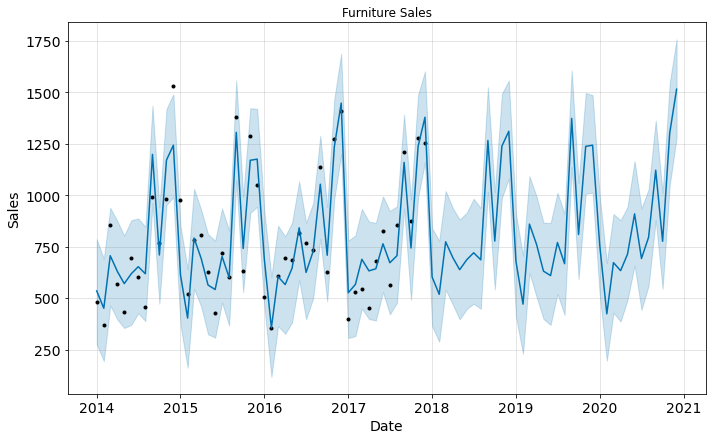

In [ ]:
plt.figure(figsize = (16,7))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

<Figure size 1152x504 with 0 Axes>

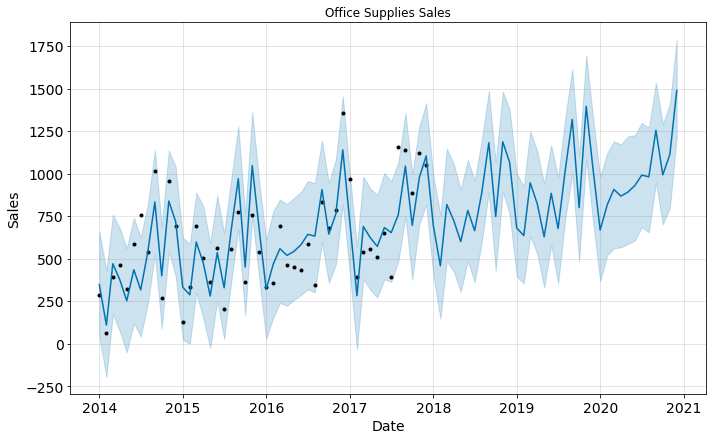

In [ ]:
plt.figure(figsize = (16,7))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')

plt.title('Office Supplies Sales')
plt.show()

Compare the Two Forecasts

Furniture Vs Technology

In [ ]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
Tech_names = ['Tech_%s' % column for column in Tech_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_Tech_forecast = Tech_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_Tech_forecast.columns = Tech_names

forecast = pd.merge(merge_furniture_forecast, merge_Tech_forecast,
                   how = 'inner', left_on = 'furniture_ds',right_on = 'Tech_ds')

forecast = forecast.rename(columns = {'furniture_ds': 'Date'}).drop('Tech_ds', axis = 1)

forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat,Tech_trend,Tech_yhat_lower,Tech_yhat_upper,Tech_trend_lower,Tech_trend_upper,Tech_additive_terms,Tech_additive_terms_lower,Tech_additive_terms_upper,Tech_yearly,Tech_yearly_lower,Tech_yearly_upper,Tech_multiplicative_terms,Tech_multiplicative_terms_lower,Tech_multiplicative_terms_upper,Tech_yhat
0,2014-01-01,726.057713,275.801615,786.599428,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,0.0,0.0,0.0,535.372051,952.355848,202.488053,1279.778642,952.355848,952.355848,-220.575922,-220.575922,-220.575922,-220.575922,-220.575922,-220.575922,0.0,0.0,0.0,731.779926
1,2014-02-01,727.494023,194.239100,691.907230,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,0.0,0.0,0.0,451.116320,958.476983,-183.755161,875.767325,958.476983,958.476983,-613.862112,-613.862112,-613.862112,-613.862112,-613.862112,-613.862112,0.0,0.0,0.0,344.614871
2,2014-03-01,728.791335,464.593204,939.087178,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,0.0,0.0,0.0,706.401580,964.005750,612.791109,1665.604636,964.005750,964.005750,181.810553,181.810553,181.810553,181.810553,181.810553,181.810553,0.0,0.0,0.0,1145.816303
3,2014-04-01,730.227645,396.743106,875.069281,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,0.0,0.0,0.0,630.086487,970.126885,67.629438,1218.907590,970.126885,970.126885,-328.523260,-328.523260,-328.523260,-328.523260,-328.523260,-328.523260,0.0,0.0,0.0,641.603626
4,2014-05-01,731.617622,355.081304,803.952410,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,0.0,0.0,0.0,570.801960,976.050565,203.806483,1282.396027,976.050565,976.050565,-237.352937,-237.352937,-237.352937,-237.352937,-237.352937,-237.352937,0.0,0.0,0.0,738.697628


Furniture Vs Office supplies

In [ ]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast,
                   how = 'inner', left_on = 'furniture_ds',
                   right_on = 'office_ds')

forecast = forecast.rename(columns = {'furniture_ds': 'Date'}).drop('office_ds', axis = 1)

forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat,office_trend,office_yhat_lower,office_yhat_upper,office_trend_lower,office_trend_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,275.801615,786.599428,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,0.0,0.0,0.0,535.372051,487.530759,41.897069,659.869644,487.530759,487.530759,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,194.239100,691.907230,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,0.0,0.0,0.0,451.116320,494.918445,-195.333060,429.905405,494.918445,494.918445,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,464.593204,939.087178,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,0.0,0.0,0.0,706.401580,501.591193,173.540218,758.626610,501.591193,501.591193,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,396.743106,875.069281,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,0.0,0.0,0.0,630.086487,508.978878,70.942407,678.177501,508.978878,508.978878,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,355.081304,803.952410,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,0.0,0.0,0.0,570.801960,516.128251,-50.329686,561.043687,516.128251,516.128251,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


Trend and Forecast Visualization

KeyError: ignored

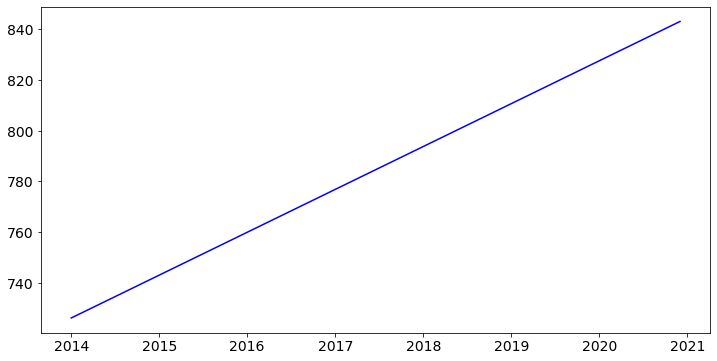

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(forecast['Date'], forecast['furniture_trend'],'b-',label='Furniture')
plt.plot(forecast['Date'], forecast['Tech_trend'], 'r-',label='Technology')
plt.legend() 
plt.xlabel('Date') 
plt.ylabel('Sales')
plt.title('Furniture vs. Technology Sales Trend')
plt.show()

Furniture Vs Office supplies

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(forecast['Date'], forecast['furniture_trend'],'b-',label='Furniture')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-',label='Office supplies')
plt.legend() 
plt.xlabel('Date') 
plt.ylabel('Sales')
plt.title('Furniture vs. Office supplies Sales Trend')
plt.show()

Trends and Patterns

In [ ]:
furniture_model.plot_components(furniture_forecast)
plt.show()

In [ ]:
Tech_model.plot_components(Tech_forecast)
plt.show()

In [ ]:
office_model.plot_components(office_forecast)
plt.show()